In [2]:
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/dcm/102651630/img_1.dcm
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz
# /scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz

In [3]:
import os, sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
from scipy import ndimage as ndi
from skimage import filters
from skimage import measure
import skimage
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r0v3zh7u because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import SimpleITK as sitk

# ref https://gist.github.com/pangyuteng/7f54dbfcd67fb9d43a85f8c6818fca7b
def imread(fpath):
    if fpath.endswith('.list'):
        with open(fpath,'r') as f:
            dicom_names = [x for x in f.read().split('\n') if len(x) > 0]
        if not os.path.exists(dicom_names[0]):
            dicom_names = [os.path.join(os.path.dirname(fpath),x) for x in dicom_names]
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(dicom_names)
    else:
        reader= sitk.ImageFileReader()
        reader.SetFileName(fpath)
    img = reader.Execute()
    arr = sitk.GetArrayFromImage(img)    
    spacing = img.GetSpacing()
    origin = img.GetOrigin()
    direction = img.GetDirection()
    return img

def imwrite(fpath,arr,spacing,origin,direction,use_compression=True):
    img = sitk.GetImageFromArray(arr)
    img.SetSpacing(spacing)
    img.SetOrigin(origin)
    img.SetDirection(direction)
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(fpath)
    writer.SetUseCompression(use_compression)
    writer.Execute(img)

# ref https://gist.github.com/mrajchl/ccbd5ed12eb68e0c1afc5da116af614a
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    
    # Resample images to out_spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [5]:
#img_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/image/102651630.nii.gz'
#mask_file = '/scratch2/personal/pteng/dataset/rawlung/RESEARCH/mask/102651630.nii.gz'
img_file = 'image.nii.gz'
mask_file = 'mask.nii.gz'
resampled_img_file = 'resampled_image.nii.gz'

In [6]:
!ls 

Dockerfile						 image.nii.gz
README.md						 mask.nii.gz
Untitled.ipynb						 requirements.txt
flattened-lof.nii.gz					 resampled_image.nii.gz
flattened-rhf.nii.gz					 viz-fiss-dallas.ipynb
flattened-rof.nii.gz					 viz-fiss-pteng.ipynb
frangi_multiscale_vessel_enhancement_filtering_1998.pdf


In [7]:
img_obj = imread(img_file)
spacing = img_obj.GetSpacing()
print('original spacing',spacing)
mask_obj = imread(mask_file)
out_spacing = [1.0, 1.0, 1.0]
img_obj = resample_img(img_obj,out_spacing=out_spacing,is_label=False)
mask_obj = resample_img(mask_obj,out_spacing=out_spacing,is_label=True)

mask = sitk.GetArrayFromImage(mask_obj)
img = sitk.GetArrayFromImage(img_obj)
spacing = img_obj.GetSpacing()
origin = img_obj.GetOrigin()
direction = img_obj.GetDirection()


original spacing (0.6796875, 0.6796875, 0.5)


In [8]:
print(spacing)

(1.0, 1.0, 1.0)


In [9]:
if not os.path.exists(resampled_img_file):
    writer = sitk.ImageFileWriter()    
    writer.SetFileName(resampled_img_file)
    writer.SetUseCompression(True)
    writer.Execute(img_obj)

In [10]:
img.dtype,mask.dtype

(dtype('int16'), dtype('int16'))

In [11]:
print(img.shape,mask.shape)
print(spacing,origin,direction)

(280, 348, 348) (280, 348, 348)
(1.0, 1.0, 1.0) (-164.66015625, -333.16015625, 1210.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)


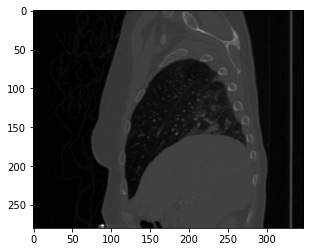

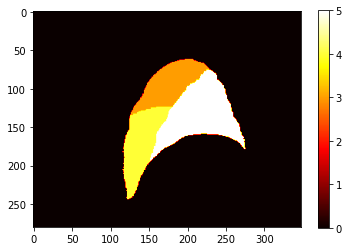

In [12]:
ind = int(1/4*img.shape[2])
plt.figure(0)
plt.imshow(img[:,:,ind],cmap='gray')
plt.figure(1)
plt.imshow(mask[:,:,ind],cmap='hot')
plt.colorbar()

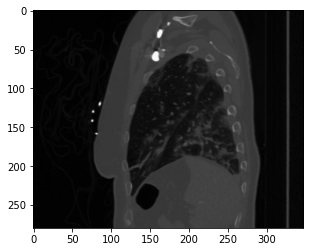

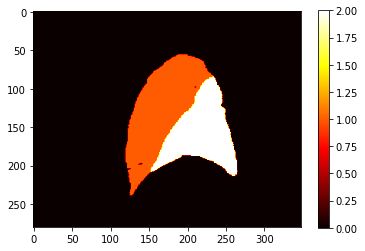

In [13]:
ind = int(3/4*img.shape[2])
plt.figure(0)
plt.imshow(img[:,:,ind],cmap='gray')
plt.figure(1)
plt.imshow(mask[:,:,ind],cmap='hot')
plt.colorbar()

In [14]:
tmp = {
    0:'bkgd',
    1:'lll',
    2:'lul',
    3:'rul',
    4:'rml',
    5:'rll',
}
print(np.unique(mask))
print(tmp)
alt_term ='''
left oblique (major) fissure (LOF)
right oblique (major) fissure (ROF) separates the lower lobe from the middle and upper lobes
the right horizontal (minor) fissure (RHF) separates the middle and upper lobes of the right lung
based on "SE Gerard et al, FissureNet: A Deep Learning Approach For Pulmonary Fissure Detection in CT Images"
'''
print(alt_term)

[0 1 2 3 4 5]
{0: 'bkgd', 1: 'lll', 2: 'lul', 3: 'rul', 4: 'rml', 5: 'rll'}

left oblique (major) fissure (LOF)
right oblique (major) fissure (ROF) separates the lower lobe from the middle and upper lobes
the right horizontal (minor) fissure (RHF) separates the middle and upper lobes of the right lung
based on "SE Gerard et al, FissureNet: A Deep Learning Approach For Pulmonary Fissure Detection in CT Images"



In [15]:
tmp = np.sum(img,axis=0)
print(tmp.shape)

(348, 348)


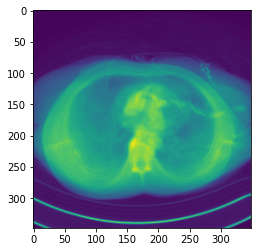

In [16]:
plt.imshow(tmp)

In [17]:
skimage.__version__

'0.17.2'

In [18]:
sigmas = list(np.arange(1, 3, 0.5))
print(sigmas)

[1.0, 1.5, 2.0, 2.5]


In [19]:
sigmas = list(np.arange(1, 3, 0.5)) # using sigma < 2 to enhance thin line.

# justification:
# 
# story 1
# + physical fissure is 0.2mm thick (ref https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2359730 ).
# + 1mm isotropic voxel, thus fissure in 1-d is 0.2 "voxel" thick.
#
# story 2
# + visualizing the image, fissure seems to be 2 voxel thick, with mean intensity as -700 HU.
# 
# seems to be a disconnect between story 1  vs 2, likely can be explained by partial volume effect.
# thus still need a range of sigma to boost plate like structure.?
#

def get_projections(img,mask,ind0,ind1):

    if isinstance(ind0,list):
        lobe0 = np.logical_or(mask==ind0[0],mask==ind0[1])
    else:
        lobe0 = mask==ind0
        
    lobe0 = ndi.binary_dilation(lobe0,iterations=5)
    lobe0 = lobe0.astype(int)

    lobe1 = mask==ind1
    lobe1 = ndi.binary_dilation(lobe1,iterations=5)
    lobe1 = lobe1.astype(int)

    assumed_fissure_location = ((lobe0+lobe1)==2) # 10mm above and below
    del lobe0, lobe1
    
    # min,max val based on: SE Gerard, FissureNet: a deep learning approach for pulmonary fissure detection in CT images
    min_val,max_val = -1024,-200
    # pteng: max val too high, intensity at fissure is ~-700 for sample case.
    min_val,max_val = -1024,-700
    rescaled_img = ((img.astype(np.float)-(min_val))/(max_val-min_val)).clip(0,1)
    
    # project with sum to 2d image for visualization purpose
    img_only_fiss=rescaled_img.copy()
    img_only_fiss[assumed_fissure_location==0]=0
    intensity_proj = np.nanmean(img_only_fiss,axis=0)
    del img_only_fiss # save space
    
    # old-school frangi filter
    # ref https://scikit-image.org/docs/0.15.x/api/skimage.filters.html
    # src https://github.com/scikit-image/scikit-image/blob/v0.17.2/skimage/filters/ridges.py#L357
    enhanced = filters.frangi(
        rescaled_img,
        sigmas=sigmas,
        alpha=0.0001, # ?alpha reduced from 0.5 to 0.001 to enhance plate like structure
        beta=0.5,
        gamma=15,
        black_ridges=False)
    
    #scale_range=None,
    #scale_step=None,
    #beta1=None,
    #beta2=None,
    
    enhanced_only_fiss=enhanced.copy()
    enhanced_only_fiss[assumed_fissure_location==0]=0
    enhanced_proj = np.nansum(enhanced_only_fiss,axis=0)
    del enhanced_only_fiss # save space
    
    return intensity_proj,enhanced_proj

mylist = [
    ('lof',1,2),
    ('rof',[3,4],5),
    ('rhf',3,4),
]

#mylist = [
#    ('rhf',3,4),
#]

mydict = {}
for n,key in enumerate(mylist):
    name,ind0,ind1 = key
    mydict[name]=get_projections(img,mask,ind0,ind1)

<Figure size 432x288 with 0 Axes>

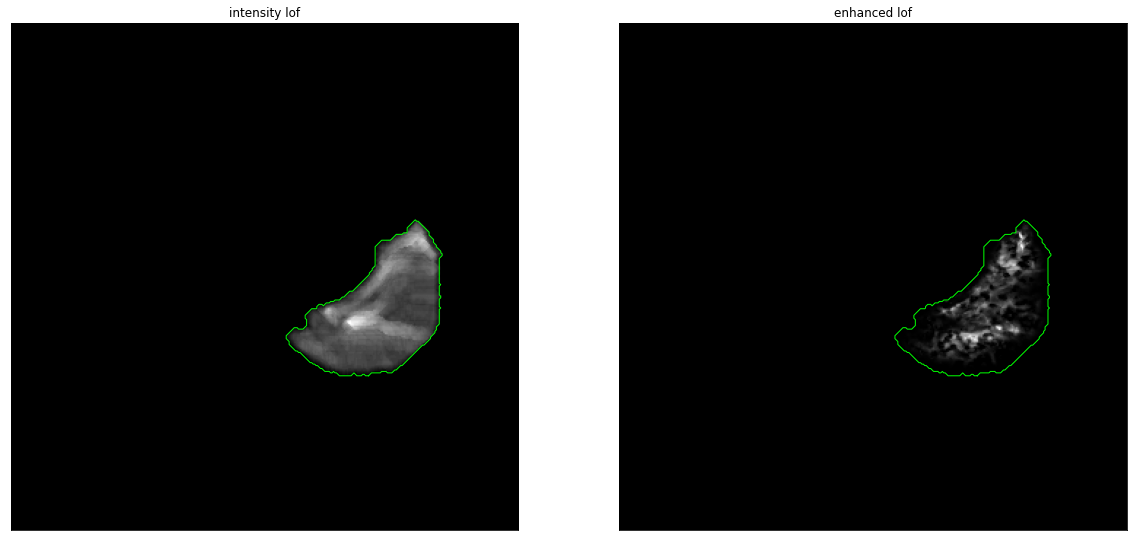

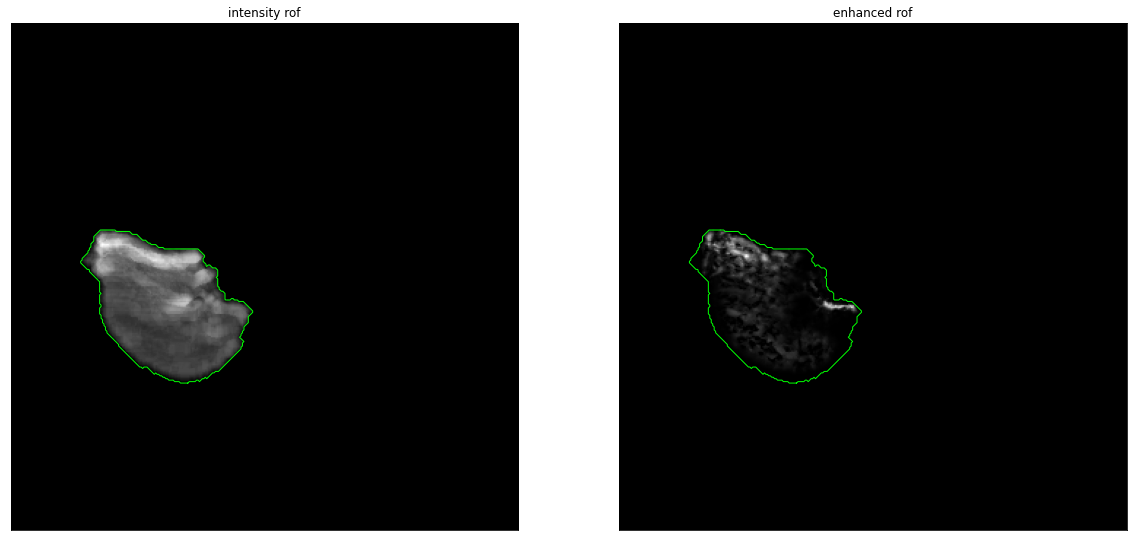

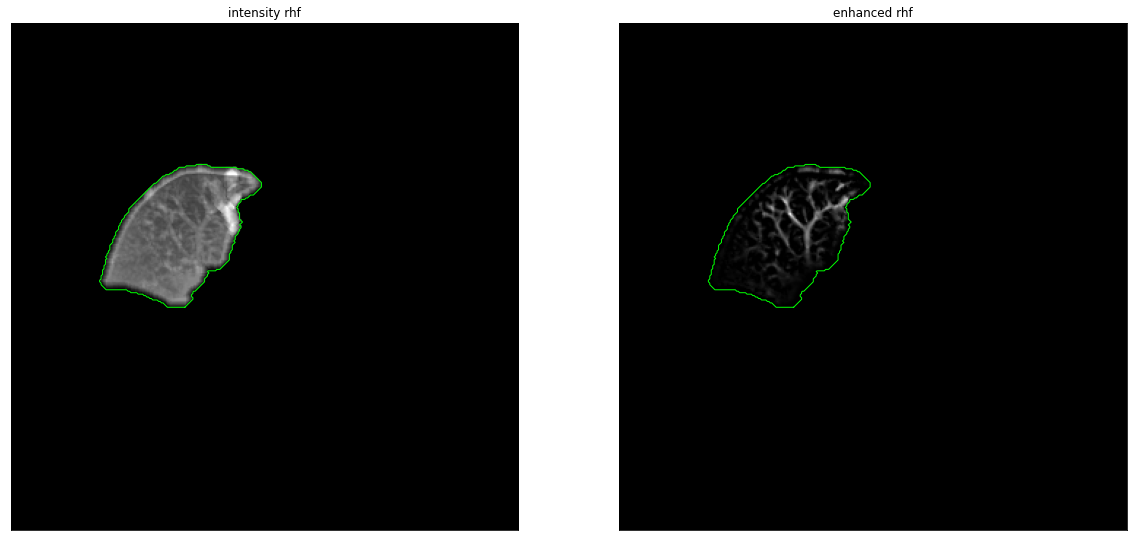

In [20]:
for n,k in enumerate(mydict.keys()):
    
    projected,sobeled = mydict[k]
    
    tmp = projected > 0 # plot border, perhaps enhance visualization
    contours = measure.find_contours(tmp, 0.5)
    
    plt.figure(n)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.set_title(f"intensity {k}")
    ax1.imshow(projected,cmap='gray')
    for contour in contours:
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=1,color=[0,1,0])

    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.set_title(f"enhanced {k}")
    ax2.imshow(sobeled,cmap='gray')
    for contour in contours:
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=1,color=[0,1,0])

    ax2.axis('image')
    ax2.set_xticks([])
    ax2.set_yticks([])


#
# expected: in enhanced image:
#    + bright shade (complete fissure) and potentially parts with low shade (no fissure),
#    + minimal vessel enhancement.
#
# current observation: 
#     + no bright shae.
#     + half of RHF may have no fissue - but have vessel-like enhancement.
#

In [21]:
# https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html

In [ ]:
sigmas = list(np.arange(1, 5, 0.5)) # using sigma < 2 to enhance thin line.

# thickness 15mm each side = 30mm
def custom_flatten(img,assumed_fissure_location,thickness=30,name=None):
    o = assumed_fissure_location
    sizex,sizey = img.shape[1],img.shape[2]
    tmp_img = np.ones((thickness,sizex,sizey))*-1024
    tmp_mask = np.zeros((thickness,sizex,sizey))
    for x in range(sizex):
        for y in range(sizey):
            t = o[:,x,y]
            l = np.where(t>0)
            if len(l[0]) > 0:
                i = l[0][0]-10
                tmp_img[:,x,y]=img[i:i+thickness,x,y]
                tmp_mask[:,x,y]=img[i:i+thickness,x,y]
            else:
                pass
    if name is not None:
        fpath = f'flattened-{name}.nii.gz'
        print(spacing,origin,direction)# bad using old meta info
        imwrite(fpath,tmp_img,spacing,origin,direction)
    return tmp_img, tmp_mask

# above is proper impl but too slow!
def get_projections_fast(img,mask,ind0,ind1,name=None):

    if isinstance(ind0,list):
        lobe0 = np.logical_or(mask==ind0[0],mask==ind0[1])
    else:
        lobe0 = mask==ind0
        
    lobe0 = ndi.binary_dilation(lobe0,iterations=5)
    lobe0 = lobe0.astype(int)

    lobe1 = mask==ind1
    lobe1 = ndi.binary_dilation(lobe1,iterations=5)
    lobe1 = lobe1.astype(int)

    assumed_fissure_location = ((lobe0+lobe1)==2) # 10mm above and below
    print(assumed_fissure_location.shape)
    flattened_img,flattened_fis = custom_flatten(img,assumed_fissure_location,thickness=30,name=name)
    print(flattened_fis.shape)
    # min,max val based on: SE Gerard, FissureNet: a deep learning approach for pulmonary fissure detection in CT images
    min_val,max_val = -1024,-200
    # pteng: max val too high, intensity at fissure is ~-700 for sample case.
    min_val,max_val = -1024,-700
    rescaled_img = ((flattened_img.astype(np.float)-(min_val))/(max_val-min_val)).clip(0,1)
    
    # project with sum to 2d image for visualization purpose
    img_only_fiss=rescaled_img.copy()
    img_only_fiss[flattened_fis==0]=0
    intensity_proj = np.nanmean(img_only_fiss,axis=0)
    del img_only_fiss # save space
    
    # old-school frangi filter
    # ref https://scikit-image.org/docs/0.15.x/api/skimage.filters.html
    # src https://github.com/scikit-image/scikit-image/blob/v0.17.2/skimage/filters/ridges.py#L357
    enhanced = filters.frangi(
        flattened_img,
        sigmas=sigmas,
        alpha=1, # ?alpha reduced from 0.5 to 0.001 to enhance plate like structure
        beta=0.5,
        gamma=15,
        black_ridges=False)
    
    #scale_range=None,
    #scale_step=None,
    #beta1=None,
    #beta2=None,
    
    enhanced_only_fiss=enhanced.copy()
    enhanced_only_fiss[flattened_fis==0]=0
    enhanced_proj = np.nansum(enhanced_only_fiss,axis=0)
    del enhanced_only_fiss # save space
    print('done')
    return intensity_proj,enhanced_proj

mylist = [
    ('lof',1,2),
    ('rof',[3,4],5),
    ('rhf',3,4),
]

#mylist = [
#    ('rhf',3,4),
#]

mydict = {}
for n,key in enumerate(mylist):
    name,ind0,ind1 = key
    print(name)
    mydict[name]=get_projections_fast(img,mask,ind0,ind1,name=name)

lof
(280, 348, 348)
(1.0, 1.0, 1.0) (-164.66015625, -333.16015625, 1210.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0)
(30, 348, 348)


In [ ]:
for n,k in enumerate(mydict.keys()):
    
    projected,enhanced = mydict[k]
    
    tmp = projected > 0 # plot border, perhaps enhance visualization
    contours = measure.find_contours(tmp, 0.5)
    
    plt.figure(n)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    ax1.set_title(f"intensity {k}")
    ax1.imshow(projected,cmap='gray')
    for contour in contours:
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=1,color=[0,1,0])

    ax1.axis('image')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.set_title(f"enhanced {k}")
    ax2.imshow(enhanced,cmap='gray')
    for contour in contours:
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=1,color=[0,1,0])

    ax2.axis('image')
    ax2.set_xticks([])
    ax2.set_yticks([])
